# Capstone Project - The Best Neighborhoods in Amsterdam for families with children
### Applied Data Science Capstone Project

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Explore Neighborhoods of Amsterdam](#explore)
* [Analyze each Neighborhood](#analyse)
* [Cluster Neighborhoods](#cluster)
* [Examine Clusters](#examine)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

The purpose of this project is to identify residential neighborhoods in Amsterdam, Netherlands that are suitable for families with children.

We will start by scraping the Wikipedia page List of boroughs of Amsterdam and then from the [official municipality source](https://data.amsterdam.nl/datasets/G5JpqNbhweXZSw/) a list of all neighborhoods and boroughs of the city.
Then we will find the latitude and longitude of each neighborhood. Next, we will use the Foursquare API to explore the neighborhoods. We will get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. We will use the k-means clustering algorithm to complete this task. Finally, we will use the Folium library to visualize the neighborhoods in Amsterdam and their emerging clusters.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decision are:
* Amsterdam data related to the Boroughs/Neighborhoods
* The coresponding geographical coordinates latitude and longitude of each Boroughs/Neighborhoods

Following data sources will be needed to extract/generate the required information:
* Amsterdam data related to the Boroughs/Neighborhoods will be aquired from web/Amsterdam Municipality official API
* Additional data related to the population/housing by neighborhoods will also be extracted from Amsterdam Municipality official API
* Geograpical coordinates of Boroughs/Neighborhoods from Geopy library with the Nominatim geolocator service or alternatively from the official Amsterdam Municipality API
* Venue categories and their type and location in every neighborhood will be obtained using **Foursquare API**

First download all the dependencies that we will need for this analysis.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
!pip install folium
import folium # map rendering library

import matplotlib.pyplot as plt

print('Libraries imported.')

     |████████████████████████████████| 102kB 7.4MB/s ta 0:00:011
Libraries imported.


#### Use geopy library to get the latitude and longitude values of Amsterdam

In [2]:
address = 'Amsterdam, NL'

geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

ams_center= (latitude, longitude)
print('The geograpical coordinates of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinates of Amsterdam, NL are 52.37454030000001, 4.897975505617977.


#### Read Boroughs data from web page

In [3]:
url1='https://en.wikipedia.org/wiki/Boroughs_of_Amsterdam'

boroughs = pd.read_html(url1)[1]

pop_pct = boroughs['Population']/boroughs['Population'].sum()

boroughs.insert(boroughs.shape[1], 'Population %', pop_pct)
boroughs

Borough       Area  Population Population density  \
0         Centrum (Centre)   8.04 km²       86422         13,748/km²   
1            Noord (North)  49.01 km²       94766          2,269/km²   
2     Nieuw-West(New West)  32.38 km²      151677          4,478/km²   
3              Oost (East)  30.56 km²      135767          7,635/km²   
4                     West   9.89 km²      143842         15,252/km²   
5  Westpoort(West Gateway)     10 km²         192             10/km²   
6             Zuid (South)  17.41 km²      144432          9,349/km²   
7      Zuidoost(Southeast)  22.08 km²       87854          4,391/km²   

   Location (in green)                                     Neighbourhoods  \
0                  NaN  Binnenstad, Grachtengordel, Haarlemmerbuurt, J...   
1                  NaN  Banne Buiksloot, Buiksloot, Buikslotermeer, Fl...   
2                  NaN  Geuzenveld, Nieuw Sloten, Oostoever, Osdorp, O...   
3                  NaN  IJburg, Indische Buurt, Eastern Docklands, Oud...   
4                  NaN  Frederik Hendrikbuurt, Houthaven, Spaarndammer...   
5                  NaN                                          Westpoort   
6                  NaN  Apollobuurt, Buitenveldert, Hoofddorppleinbuur...   
7                  NaN    Bijlmermeer, Venserpolder, Gaasperdam, Driemond   

   Population %  
0      0.102280  
1      0.112155  
2      0.179510  
3      0.160680  
4      0.170237  
5      0.000227  
6      0.170935  
7      0.103975

In [4]:
#Create a new column called 'new Borough' having just the first part of the Borough (before '(') and add the 'Amsterdam, NL' part, 
#then rename it to 'Borough' as this will be used further

boroughs_= boroughs['Borough'].str.split("(" , expand=True)
boroughs_.rename(columns={0:'new Borough'}, inplace=True)

df_ams = pd.concat([boroughs, boroughs_['new Borough']], axis=1)
df_ams['Borough'] = df_ams['new Borough']+" Amsterdam, NL"
df_ams=df_ams[['Borough' ,'Area','Population', 'Population density', 'Neighbourhoods', 'Population %']]
df_ams

Borough       Area  Population Population density  \
0    Centrum  Amsterdam, NL   8.04 km²       86422         13,748/km²   
1      Noord  Amsterdam, NL  49.01 km²       94766          2,269/km²   
2  Nieuw-West Amsterdam, NL  32.38 km²      151677          4,478/km²   
3       Oost  Amsterdam, NL  30.56 km²      135767          7,635/km²   
4        West Amsterdam, NL   9.89 km²      143842         15,252/km²   
5   Westpoort Amsterdam, NL     10 km²         192             10/km²   
6       Zuid  Amsterdam, NL  17.41 km²      144432          9,349/km²   
7    Zuidoost Amsterdam, NL  22.08 km²       87854          4,391/km²   

                                      Neighbourhoods  Population %  
0  Binnenstad, Grachtengordel, Haarlemmerbuurt, J...      0.102280  
1  Banne Buiksloot, Buiksloot, Buikslotermeer, Fl...      0.112155  
2  Geuzenveld, Nieuw Sloten, Oostoever, Osdorp, O...      0.179510  
3  IJburg, Indische Buurt, Eastern Docklands, Oud...      0.160680  
4  Frederik Hendrikbuurt, Houthaven, Spaarndammer...      0.170237  
5                                          Westpoort      0.000227  
6  Apollobuurt, Buitenveldert, Hoofddorppleinbuur...      0.170935  
7    Bijlmermeer, Venserpolder, Gaasperdam, Driemond      0.103975

In [5]:
#Get Geographical coordinates for all boroughs and create a dataframe with this information

def get_coordinates(borough):
    addresses= []
    latitudes= []
    longitudes= []
    
    for borough in list_boroughs:
        address = borough

        geolocator = Nominatim(user_agent="on_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        print('The geograpical coordinates of {} are {}, {}.'.format(address, latitude, longitude))
        addresses.append(address)
        latitudes.append(latitude)
        longitudes.append(longitude)
    
    return addresses, latitudes, longitudes
    
list_boroughs = df_ams['Borough']
adr, lat, lon = get_coordinates(list_boroughs)
df_locations = pd.DataFrame({'Borough': adr,
                             'Latitude': lat,
                             'Longitude': lon})
df_locations

The geograpical coordinates of Centrum  Amsterdam, NL are 52.3737301, 4.8956908.
The geograpical coordinates of Noord  Amsterdam, NL are 52.4017392, 4.9153521.
The geograpical coordinates of Nieuw-West Amsterdam, NL are 52.3637773, 4.8138122.
The geograpical coordinates of Oost  Amsterdam, NL are 52.3566078, 4.9305774.
The geograpical coordinates of West Amsterdam, NL are 52.3727483, 4.8898462.
The geograpical coordinates of Westpoort Amsterdam, NL are 52.4114676, 4.800573466659271.
The geograpical coordinates of Zuid  Amsterdam, NL are 52.3391945, 4.8742325.
The geograpical coordinates of Zuidoost Amsterdam, NL are 52.3105137, 4.9606947.


Borough   Latitude  Longitude
0    Centrum  Amsterdam, NL  52.373730   4.895691
1      Noord  Amsterdam, NL  52.401739   4.915352
2  Nieuw-West Amsterdam, NL  52.363777   4.813812
3       Oost  Amsterdam, NL  52.356608   4.930577
4        West Amsterdam, NL  52.372748   4.889846
5   Westpoort Amsterdam, NL  52.411468   4.800573
6       Zuid  Amsterdam, NL  52.339194   4.874232
7    Zuidoost Amsterdam, NL  52.310514   4.960695

In [6]:
# Update Amsterdam boroughs dataframe with the coordinates of each Borough
df_ams = pd.merge(df_ams, df_locations, on = 'Borough', how='left')
df_ams

Borough       Area  Population Population density  \
0    Centrum  Amsterdam, NL   8.04 km²       86422         13,748/km²   
1      Noord  Amsterdam, NL  49.01 km²       94766          2,269/km²   
2  Nieuw-West Amsterdam, NL  32.38 km²      151677          4,478/km²   
3       Oost  Amsterdam, NL  30.56 km²      135767          7,635/km²   
4        West Amsterdam, NL   9.89 km²      143842         15,252/km²   
5   Westpoort Amsterdam, NL     10 km²         192             10/km²   
6       Zuid  Amsterdam, NL  17.41 km²      144432          9,349/km²   
7    Zuidoost Amsterdam, NL  22.08 km²       87854          4,391/km²   

                                      Neighbourhoods  Population %   Latitude  \
0  Binnenstad, Grachtengordel, Haarlemmerbuurt, J...      0.102280  52.373730   
1  Banne Buiksloot, Buiksloot, Buikslotermeer, Fl...      0.112155  52.401739   
2  Geuzenveld, Nieuw Sloten, Oostoever, Osdorp, O...      0.179510  52.363777   
3  IJburg, Indische Buurt, Eastern Docklands, Oud...      0.160680  52.356608   
4  Frederik Hendrikbuurt, Houthaven, Spaarndammer...      0.170237  52.372748   
5                                          Westpoort      0.000227  52.411468   
6  Apollobuurt, Buitenveldert, Hoofddorppleinbuur...      0.170935  52.339194   
7    Bijlmermeer, Venserpolder, Gaasperdam, Driemond      0.103975  52.310514   

   Longitude  
0   4.895691  
1   4.915352  
2   4.813812  
3   4.930577  
4   4.889846  
5   4.800573  
6   4.874232  
7   4.960695

So far we could only find the geographical coordinates for each Borough, but since there are only 8 boroughs clustering the data would not make more sense, so we would like to get the information for all Amsterdam's neighborhoods...so I've searched more and found there is an official source for the Municipality of Amsterdam which has maps and data available.

#### Get information of Boroughs and Neighborhoods from the Municipality of Amsterdam - Research, Information and Statistics

In [7]:
ams_neighborhoods = pd.read_csv('https://maps.amsterdam.nl/open_geodata/excel.php?KAARTLAAG=GEBIED_BUURTEN&THEMA=gebiedsindeling', sep=';')

ams_neighborhoods.head()

OBJECTNUMMER Buurt_code                          Buurt  \
0             1       F81d            Calandlaan/Lelylaan   
1             2       F81e                Osdorp Zuidoost   
2             3       F82a            Osdorp Midden Noord   
3             4       F82b             Osdorp Midden Zuid   
4             5       F82c  Zuidwestkwadrant Osdorp Noord   

  Buurtcombinatie_code Stadsdeel_code    Opp_m2  \
0                  F81              F  275360.0   
1                  F81              F  519366.0   
2                  F82              F  215541.0   
3                  F82              F  258379.0   
4                  F82              F  240774.0   

                                         WKT_LNG_LAT  \
0  POLYGON((4.800801 52.355175,4.809055 52.356842...   
1  POLYGON((4.818583 52.357519,4.818622 52.356295...   
2  POLYGON((4.786657 52.362712,4.795326 52.364434...   
3  POLYGON((4.788293 52.359736,4.796917 52.36148,...   
4  POLYGON((4.790209 52.356207,4.799258 52.358027...   

                                         WKT_LAT_LNG       LNG        LAT  \
0  POLYGON((52.355175 4.800801,52.356842 4.809055...  4.809697  52.355708   
1  POLYGON((52.357519 4.818583,52.356295 4.818622...  4.811344  52.353736   
2  POLYGON((52.362712 4.786657,52.364434 4.795326...  4.791792  52.362078   
3  POLYGON((52.359736 4.788293,52.36148 4.796917,...  4.793781  52.358838   
4  POLYGON((52.356207 4.790209,52.358027 4.799258...  4.795597  52.355523   

   Unnamed: 10  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [8]:
ams_neighborhoods = ams_neighborhoods[['Buurt', 'Buurt_code','Stadsdeel_code', 'Opp_m2', 'LAT', 'LNG']].reset_index()
ams_neighborhoods.rename(columns={'Buurt' : 'Neighborhood' ,'Buurt_code' : 'Neighborhood code' , 'Stadsdeel_code' :'Borough code' , 'Opp_m2' :'Area m2', 'LAT':'Latitude', 'LNG':'Longitude'} ,inplace=True)
ams_neighborhoods.head()

index                   Neighborhood Neighborhood code Borough code  \
0      0            Calandlaan/Lelylaan              F81d            F   
1      1                Osdorp Zuidoost              F81e            F   
2      2            Osdorp Midden Noord              F82a            F   
3      3             Osdorp Midden Zuid              F82b            F   
4      4  Zuidwestkwadrant Osdorp Noord              F82c            F   

    Area m2   Latitude  Longitude  
0  275360.0  52.355708   4.809697  
1  519366.0  52.353736   4.811344  
2  215541.0  52.362078   4.791792  
3  258379.0  52.358838   4.793781  
4  240774.0  52.355523   4.795597

In [9]:
ams_boroughs = pd.read_csv('https://maps.amsterdam.nl/open_geodata/excel.php?KAARTLAAG=GEBIED_STADSDELEN&THEMA=gebiedsindeling', sep=';')
ams_boroughs

OBJECTNUMMER Stadsdeel_code   Stadsdeel    Opp_m2  \
0             1              A     Centrum   8043500   
1             2              B   Westpoort  28991600   
2             3              E        West  10629900   
3             4              F  Nieuw-West  38015500   
4             5              K        Zuid  17274000   
5             6              M        Oost  30594900   
6             7              N       Noord  63828800   
7             8              T    Zuidoost  22113700   

                                         WKT_LNG_LAT  \
0  POLYGON((4.932973 52.3704,4.932942 52.370539,4...   
1  POLYGON((4.885861 52.39937,4.882702 52.401695,...   
2  POLYGON((4.895084 52.388684,4.894675 52.389933...   
3  POLYGON((4.850498 52.364232,4.850459 52.365189...   
4  POLYGON((4.914989 52.342139,4.914945 52.342421...   
5  POLYGON((5.039059 52.354569,5.038812 52.358098...   
6  POLYGON((5.079164 52.388647,5.074264 52.413831...   
7  POLYGON((5.021546 52.302451,5.021464 52.303129...   

                                         WKT_LAT_LNG       LNG        LAT  \
0  POLYGON((52.3704 4.932973,52.370539 4.932942,5...  4.903712  52.373297   
1  POLYGON((52.39937 4.885861,52.401695 4.882702,...  4.807319  52.411465   
2  POLYGON((52.388684 4.895084,52.389933 4.894675...  4.865216  52.377879   
3  POLYGON((52.364232 4.850498,52.365189 4.850459...  4.802676  52.363591   
4  POLYGON((52.342139 4.914989,52.342421 4.914945...  4.866063  52.341721   
5  POLYGON((52.354569 5.039059,52.358098 5.038812...  4.967149  52.350438   
6  POLYGON((52.388647 5.079164,52.413831 5.074264...  4.967446  52.399439   
7  POLYGON((52.302451 5.021546,52.303129 5.021464...  4.975444  52.304654   

   Unnamed: 8  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  
5         NaN  
6         NaN  
7         NaN

In [10]:
ams_boroughs = ams_boroughs[['Stadsdeel_code','Stadsdeel','Opp_m2', 'LAT', 'LNG']]
ams_boroughs.rename(columns ={'Stadsdeel_code' :'Borough code' ,'Stadsdeel':'Borough', 'Opp_m2' :'Borough Area m2', 'LAT':'Borough Latitude', 'LNG':'Borough Longitude'}, inplace=True)
ams_boroughs

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


Borough code     Borough  Borough Area m2  Borough Latitude  \
0            A     Centrum          8043500         52.373297   
1            B   Westpoort         28991600         52.411465   
2            E        West         10629900         52.377879   
3            F  Nieuw-West         38015500         52.363591   
4            K        Zuid         17274000         52.341721   
5            M        Oost         30594900         52.350438   
6            N       Noord         63828800         52.399439   
7            T    Zuidoost         22113700         52.304654   

   Borough Longitude  
0           4.903712  
1           4.807319  
2           4.865216  
3           4.802676  
4           4.866063  
5           4.967149  
6           4.967446  
7           4.975444

In [11]:
ams_data = pd.merge(ams_neighborhoods, ams_boroughs , on='Borough code', how ='left')

print(ams_data.shape)
ams_data.head(10)

(481, 11)


index                   Neighborhood Neighborhood code Borough code  \
0      0            Calandlaan/Lelylaan              F81d            F   
1      1                Osdorp Zuidoost              F81e            F   
2      2            Osdorp Midden Noord              F82a            F   
3      3             Osdorp Midden Zuid              F82b            F   
4      4  Zuidwestkwadrant Osdorp Noord              F82c            F   
5      5   Zuidwestkwadrant Osdorp Zuid              F82d            F   
6      6                        De Punt              F83a            F   
7      7        Bedrijvencentrum Osdorp              F83b            F   
8      8          Overtoomse Veld Noord              F86a            F   
9      9            Rembrandtpark Noord              F86c            F   

    Area m2   Latitude  Longitude     Borough  Borough Area m2  \
0  275360.0  52.355708   4.809697  Nieuw-West         38015500   
1  519366.0  52.353736   4.811344  Nieuw-West         38015500   
2  215541.0  52.362078   4.791792  Nieuw-West         38015500   
3  258379.0  52.358838   4.793781  Nieuw-West         38015500   
4  240774.0  52.355523   4.795597  Nieuw-West         38015500   
5  402284.0  52.350535   4.797757  Nieuw-West         38015500   
6  481657.0  52.356332   4.784402  Nieuw-West         38015500   
7  117961.0  52.360842   4.784481  Nieuw-West         38015500   
8  344673.0  52.367066   4.838088  Nieuw-West         38015500   
9  304271.0  52.366990   4.846331  Nieuw-West         38015500   

   Borough Latitude  Borough Longitude  
0         52.363591           4.802676  
1         52.363591           4.802676  
2         52.363591           4.802676  
3         52.363591           4.802676  
4         52.363591           4.802676  
5         52.363591           4.802676  
6         52.363591           4.802676  
7         52.363591           4.802676  
8         52.363591           4.802676  
9         52.363591           4.802676

In [12]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(ams_data['Borough'].unique()),
        ams_data.shape[0]
    )
)

The dataframe has 8 boroughs and 481 neighborhoods.


In [13]:
# create map of Amsterdam using latitude and longitude values
map_ams = folium.Map(location=ams_center, zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(ams_data['Latitude'], ams_data['Longitude'], ams_data['Borough'], ams_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ams)  
    
map_ams

Get additional data from the Municipality on neighborhood level for topics related to population, primary schools, housing etc.

In [14]:
ams= 'https://api.data.amsterdam.nl/dcatd/datasets/G5JpqNbhweXZSw/purls/LXGOPUQQfAXBbg'
dfams = pd.read_csv(ams, sep=';', low_memory=False)

#get only latest year data and area code (gebiedcode15) for neighborhoods - regex searh for pattern
dfams= dfams[dfams['jaar']==2020]
dfams.head()

import string

#get only the data for neighborhoods and boroughs/ regex searh for pattern
dfams1 = dfams[dfams['gebiedcode15'].str.match("[A-Z]\d\d[a-z]")] #rows with info for neighborhoods
dfams2 = dfams[dfams['gebiedcode15'].isin(list(string.ascii_uppercase))] #rows with info for boroughs
#dfams3 = dfams[(dfams['gebiedcode15'].str.match("[A-Z]\d\d[a-z]")) or (dfams['gebiedcode15'].isin(list(string.ascii_uppercase)))]
print(dfams1.shape) 
dfams1.head()
print(dfams2.shape)
dfams2.head()

dfams = dfams1.append(dfams2) #final table containing info for boroughs and neighborhoods
print(dfams.shape) #check the size for the final table
dfams.head()

(86814, 4)
(1836, 4)
(88650, 4)


jaar gebiedcode15 variabele  waarde
2429887  2020         E12b   BEV0_17    68.0
2429888  2020         E12a   BEV0_17   523.0
2429889  2020         E13a   BEV0_17   370.0
2429890  2020         E13b   BEV0_17   374.0
2429891  2020         E13e   BEV0_17   182.0

In [15]:
#get the definition for the variables to understand their meanings
urldef = 'https://api.data.amsterdam.nl/dcatd/datasets/G5JpqNbhweXZSw/purls/_V6g35HdgsK2nA'
df_def = pd.read_csv(urldef, sep=',')
print(df_def.columns)
df_def = df_def[['Variabele', 'Topic area', 'Label_1' ,'Definition']]

print(df_def.shape)
df_def.head()

Index(['SORT', 'Begrotingsprogramma', 'THEMA', 'Variabele', 'Label',
       'Labelkort', 'Definitie', 'Bron', 'Peildatum',
       'Verschijningsfrequentie', 'Rekeneenheid', 'Symbool', 'GROEP', 'format',
       'Berekende variabelen', 'Thema Kerncijfertabel',
       'Tussenkopje_kerncijfertabel', 'Kleurenpalet', 'LegendaCode',
       'SD minimum Bevtotaal', 'SD minimum WvoorrBAG', 'Topic area', 'Label_1',
       'Definition', 'Reference date', 'Frequency'],
      dtype='object')
(801, 4)


Variabele  Topic area                      Label_1  \
0     BEVTOTAAL  Population                   Population   
1  BEV_PROG2015  Population   Population projection 2015   
2  BEV_PROG2016  Population   Population projection 2016   
3  BEV_PROG2018  Population  Population  projection 2018   
4  BEV_PROG2019  Population  Population  projection 2019   

                                          Definition  
0  Number of people registered in Amsterdam on Ja...  
1  Projection in 2015 for the population size on ...  
2  Projection in 2016 for the population size on ...  
3  Projection in 2018 for the population size on ...  
4  Projection in 2019 for the population size on ...

In [16]:
#check the variable definition in order to select only some variables relevant for our analysis
#df_def['Label_1'].unique()

In [17]:
#select only the variables relevant for our analysis
cols =['Population',
'Population density',
'New urbanites (%)',
'Households: % couple with children',
'Housing density',
'Property: % Owner-occupied',
'Average house-value for tax purposes per m2',
'Neighbourhood: Satisfaction with neighbourhood (1-10)',
'Green spaces (1-10)',
'Playing facilities (1-10)',
'Safety index total',
'Primary education: schools']
df_def = df_def[df_def['Label_1'].isin (cols)]
df_def #check the variables definition table

Variabele    Topic area  \
0           BEVTOTAAL    Population   
19           BEVDICHT    Population   
48    BEVNSTEDELING_P    Population   
63   BEVPAARMKINDHH_P    Population   
178            WDICHT       Housing   
191           WKOOP_P       Housing   
211           WWOZ_M2       Housing   
230          LBUURT_R       Housing   
240         ORGROEN_R  Public space   
241  ORAANBODSPELEN_R  Public space   
277        VVEILIGH_I        Safety   
669           OSCHBAO     Education   

                                               Label_1  \
0                                           Population   
19                                  Population density   
48                                   New urbanites (%)   
63                  Households: % couple with children   
178                                    Housing density   
191                         Property: % Owner-occupied   
211        Average house-value for tax purposes per m2   
230  Neighbourhood: Satisfaction with neighbourhood...   
240                                Green spaces (1-10)   
241                          Playing facilities (1-10)   
277                                 Safety index total   
669                         Primary education: schools   

                                            Definition  
0    Number of people registered in Amsterdam on Ja...  
19   Number of residents per square kilometre of land.  
48   Percentage of the population classified as 'ne...  
63   Percentage of households: couple with children...  
178  Housing density: Number of homes per square ki...  
191  Percentage of addresses registered as property...  
211  Average house-value per m2 as determined by th...  
230  Average answer to the question: \r\nHow satisf...  
240  Average answer to the question: \r\nWhat is yo...  
241  Average answer to the question: \r\nWhat is yo...  
277  The Safety Index describes the safety of an ar...  
669           Number of schools for primary education.

In [18]:
# keep only the selected variables for analysis in df_def
dfams= dfams[dfams['variabele'].isin(df_def['Variabele'])]

ams_population = dfams.pivot(index='gebiedcode15', columns='variabele', values='waarde').reset_index()

print(ams_population.size)
ams_population.head()

2916


variabele gebiedcode15  BEVDICHT  BEVNSTEDELING_P  BEVPAARMKINDHH_P  \
0                    A   13985.0             39.3               8.9   
1                 A00a   18447.0             47.2               3.3   
2                 A00b    8249.0             48.5               2.7   
3                 A00c   25874.0             44.6               4.8   
4                 A00d    6562.0             57.5               5.3   

variabele  BEVTOTAAL   WDICHT  
0            87310.0   8806.0  
1             1100.0  12947.0  
2              728.0   6051.0  
3             1613.0  16057.0  
4              351.0   4917.0

Unfortunately not all columns selected from the column definition tables are available on the Neighbourhood or Borough level, so as we can see we will only have 5 columns related to Population available.

In [19]:
#rename columns
ams_population.rename(columns={'gebiedcode15':'Neighborhood code','BEVDICHT': 'Population density', 'BEVNSTEDELING_P':'New urbanities %', 'BEVPAARMKINDHH_P':'Couples with children %','BEVTOTAAL':'Population', 'WDICHT':'Housing Density'}, inplace=True)
ams_population.head()

variabele Neighborhood code  Population density  New urbanities %  \
0                         A             13985.0              39.3   
1                      A00a             18447.0              47.2   
2                      A00b              8249.0              48.5   
3                      A00c             25874.0              44.6   
4                      A00d              6562.0              57.5   

variabele  Couples with children %  Population  Housing Density  
0                              8.9     87310.0           8806.0  
1                              3.3      1100.0          12947.0  
2                              2.7       728.0           6051.0  
3                              4.8      1613.0          16057.0  
4                              5.3       351.0           4917.0

Join Population data with the Amsterdam neighborhoods data

In [20]:
#join population data to the Amsterdam data
ams_data = ams_data.merge(ams_population, on = 'Neighborhood code', how='left')

#check final table with info about Amsterdam Neighborhoods and the available population related indicators.
ams_data.head() 

index                   Neighborhood Neighborhood code Borough code  \
0      0            Calandlaan/Lelylaan              F81d            F   
1      1                Osdorp Zuidoost              F81e            F   
2      2            Osdorp Midden Noord              F82a            F   
3      3             Osdorp Midden Zuid              F82b            F   
4      4  Zuidwestkwadrant Osdorp Noord              F82c            F   

    Area m2   Latitude  Longitude     Borough  Borough Area m2  \
0  275360.0  52.355708   4.809697  Nieuw-West         38015500   
1  519366.0  52.353736   4.811344  Nieuw-West         38015500   
2  215541.0  52.362078   4.791792  Nieuw-West         38015500   
3  258379.0  52.358838   4.793781  Nieuw-West         38015500   
4  240774.0  52.355523   4.795597  Nieuw-West         38015500   

   Borough Latitude  Borough Longitude  Population density  New urbanities %  \
0         52.363591           4.802676              4735.0               7.0   
1         52.363591           4.802676              8282.0              17.6   
2         52.363591           4.802676             13403.0               3.3   
3         52.363591           4.802676             14779.0               6.5   
4         52.363591           4.802676             13789.0               9.8   

   Couples with children %  Population  Housing Density  
0                     15.0      1248.0           2512.0  
1                     14.6      4012.0           3947.0  
2                     25.1      2827.0           6656.0  
3                     26.2      3486.0           5986.0  
4                     24.1      3190.0           5615.0

# Explore Neighborhoods of Amsterdam <a name="explore"></a>

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [21]:
CLIENT_ID = '1HRZCAXQLE35NH1ZE50GVZEUGFFMWNNFL45R1VJOGDH4AZXD' # your Foursquare ID
CLIENT_SECRET = 'XMW1VG5J3P52OLOJWKL50LA1YV1E3NTWQL5IM0RQI2FOTNK2' # your Foursquare Secret
VERSION = '20201001' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1HRZCAXQLE35NH1ZE50GVZEUGFFMWNNFL45R1VJOGDH4AZXD
CLIENT_SECRET:XMW1VG5J3P52OLOJWKL50LA1YV1E3NTWQL5IM0RQI2FOTNK2


#### Let's explore the first neighborhood in our dataframe

Let's see the the name, latitude and longitude of the first neighborhood in the Amsterdam data

In [22]:
neighborhood_name = ams_data.loc[0, 'Neighborhood'] # neighborhood name
neighborhood_latitude = ams_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = ams_data.loc[0, 'Longitude'] # neighborhood longitude value

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Calandlaan/Lelylaan are 52.3557078, 4.8096969000000005.


#### Now, let's get the top 100 venues that are in the above neighborhood within a radius of 500 meters

First we will create the GET request URL.

In [23]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

Send the GET request and examine the results

In [24]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f76f488896a5805a44b0a40'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Stadsdeel Nieuw-West',
  'headerFullLocation': 'Stadsdeel Nieuw-West, Amsterdam',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 18,
  'suggestedBounds': {'ne': {'lat': 52.3602078045, 'lng': 4.817051050860141},
   'sw': {'lat': 52.351207795499995, 'lng': 4.80234274913986}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b866d45f964a5209e8931e3',
       'name': 'Toko Bandung',
       'location': {'address': 'Pieter Calandlaan 333-336',
        'lat': 52.354357760869604,
        'lng': 4.810843080812593,
        'labeledLatLngs': [{'label': 'display',
 

We see that all the information that we want is in the items key. Before we proceed, we will create the get_category_type function which extracts the category name from a JSON object.

In [25]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [26]:
#extract the items key from the results
venues = results['response']['groups'][0]['items']
#flatten JSON into a dataframe
nearby_venues = json_normalize(venues) 
#filter columns that we need for further analysis
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]
#extract the category for each row using the previously defined function
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

name             categories        lat       lng
0                  Toko Bandung  Indonesian Restaurant  52.354358  4.810843
1                         Enfes     Turkish Restaurant  52.354057  4.810545
2           Sportcentrum Caland   Gym / Fitness Center  52.354371  4.807132
3                       TK Maxx         Clothing Store  52.359155  4.805335
4                  De Meervaart                Theater  52.358970  4.807311
5                        Action         Discount Store  52.358802  4.804731
6     Winkelcentrum Osdorpplein          Shopping Mall  52.358236  4.806964
7                      Kruidvat              Drugstore  52.359389  4.806192
8                      De Serre            Snack Place  52.358866  4.804710
9                   Snackbar 88            Snack Place  52.354488  4.812280
10                     Kruidvat              Drugstore  52.359695  4.806452
11                    Shoperade          Shopping Mall  52.358246  4.806904
12  Bushalte Piet Wiedijkstraat               Bus Stop  52.357353  4.815043
13            Holland & Barrett               Pharmacy  52.359703  4.808714
14          Tramhalte Ruimzicht           Tram Station  52.359674  4.807474
15           Bushalte Ruimzicht               Bus Stop  52.359730  4.807527
16                          BCC      Electronics Store  52.359729  4.807129
17                 Fit For Free                    Gym  52.359851  4.807001

In [27]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

18 venues were returned by Foursquare.


Create a function to repeat the same process as above to all the neighborhoods in Amsterdam

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Create a function to repeat the same process as above to all the neighborhoods of Amsterdam

In [29]:
ams_venues = getNearbyVenues(names = ams_data['Neighborhood'],
                                   latitudes = ams_data['Latitude'],
                                   longitudes = ams_data['Longitude']
                                  )

#save the dataset not to send the request to Forsquare api all the time and exceed the limit API calls
ams_venues_s = ams_venues

Calandlaan/Lelylaan
Osdorp Zuidoost
Osdorp Midden Noord
Osdorp Midden Zuid
Zuidwestkwadrant Osdorp Noord
Zuidwestkwadrant Osdorp Zuid
De Punt
Bedrijvencentrum Osdorp
Overtoomse Veld Noord
Rembrandtpark Noord
Rembrandtpark Zuid
Johan Jongkindbuurt
Lucas/Andreasziekenhuis e.o.
Koningin Wilhelminaplein
Andreasterrein
Delflandpleinbuurt Oost
Delflandpleinbuurt West
Riekerhaven
Schipluidenbuurt
Riekerpolder
Park Haagseweg
Nieuw Sloten Noordwest
Nieuw Sloten Noordoost
Belgiëplein e.o.
Nieuw Sloten Zuidwest
Nieuw Sloten Zuidoost
Hemonybuurt
Gerard Doubuurt
Frans Halsbuurt
Hercules Seghersbuurt
Sarphatiparkbuurt
Willibrordusbuurt
Van der Helstpleinbuurt
Lizzy Ansinghbuurt
Cornelis Troostbuurt
Surinamepleinbuurt
Kop Zeedijk
BG-terrein e.o.
Stationsplein e.o.
Hemelrijk
Spuistraat Noord
Nieuwe Kerk e.o.
Spuistraat Zuid
Kalverdriehoek
Langestraat e.o.
Leliegracht e.o.
Felix Meritisbuurt
Leidsegracht Noord
Spiegelbuurt
Gouden Bocht
Van Loonbuurt
Amstelveldbuurt
Rembrandtpleinbuurt
Scheepvaarthuisbu

Let's summarize the venues categories by each Neighborhood and visualize it on a histogram

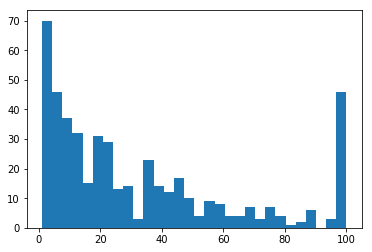

Neighborhood  Venue Category Count
0                    AMC                     5
1  Aalsmeerwegbuurt Oost                    43
2  Aalsmeerwegbuurt West                    35
3    Alexanderplein e.o.                    63
4          Alfa-driehoek                     4

In [30]:
ams_venues_count = ams_venues.groupby('Neighborhood').count().reset_index()
ams_venues_count = ams_venues_count[['Neighborhood', 'Venue Category']]
ams_venues_count.columns = ['Neighborhood', 'Venue Category Count']

plt.hist(ams_venues_count['Venue Category Count'], bins =30)
plt.show()

ams_venues_count.head()

We see that there are Neighborhoods with few venues categories, so in order to have a meaningfull analysis we will exclude those ones.

In [31]:
#create list with neighborhoods to exclude
neigh_to_exclude = ams_venues_count[ams_venues_count['Venue Category Count'] < 4]
print('Neighborhoods with less than 4 venues categories', neigh_to_exclude.shape[0])
#create filtered dataframe by excluding neighborhoods in above list
ams_venues_filt = ams_venues[~ams_venues['Neighborhood'].isin(neigh_to_exclude['Neighborhood'])]
print(ams_venues_filt.shape)
#rename filtered dataframe back to ams_venues
ams_venues = ams_venues_filt
#check counts after filtering
ams_venues.groupby('Neighborhood').size()

Neighborhoods with less than 4 venues categories 25
(15500, 7)


Neighborhood
AMC                                  5
Aalsmeerwegbuurt Oost               43
Aalsmeerwegbuurt West               35
Alexanderplein e.o.                 63
Alfa-driehoek                        4
Amstel III deel A/B Noord           21
Amstel III deel A/B Zuid             8
Amstel III deel C/D Zuid            18
Amstelglorie                         4
Amstelkwartier Noord                18
Amstelkwartier West                 23
Amstelkwartier Zuid                 26
Amstelpark                          13
Amstelveldbuurt                     89
Amsterdamse Bos                      4
Amsterdamse Poort                   60
Andreasterrein                      22
Anjeliersbuurt Noord               100
Anjeliersbuurt Zuid                100
Architectenbuurt                     5
BG-terrein e.o.                    100
Balboaplein e.o.                    42
Banne Noordoost                      5
Banne Noordwest                     12
Banne Zuidoost                       8
Banne Zuidwe

# Analyze Each Neighborhood <a name="analyse"></a>

In [32]:
ams_venues.head()

ams_venues[ams_venues['Venue Category']== 'Neighborhood']

Neighborhood  Neighborhood Latitude  \
87                        De Punt              52.356332   
5095               Zeeheldenbuurt              52.389430   
5157   Spaarndammerbuurt Zuidoost              52.387730   
9595            Scheldebuurt West              52.344405   
9672          Scheldebuurt Midden              52.344645   
9726            Scheldebuurt Oost              52.344689   
9771              IJselbuurt West              52.347579   
9915               Rijnbuurt West              52.341683   
11016         Steigereiland Noord              52.364833   
11322         Planciusbuurt Noord              52.387007   
11401          Planciusbuurt Zuid              52.384932   
14793   Middelveldsche Akerpolder              52.353541   
15080                Park de Meer              52.343558   

       Neighborhood Longitude                      Venue  Venue Latitude  \
87                   4.784402             Dijkgraafplein       52.355379   
5095                 4.888217              Prinseneiland       52.386116   
5157                 4.882102              Prinseneiland       52.386116   
9595                 4.894150              Rivierenbuurt       52.344341   
9672                 4.898535              Rivierenbuurt       52.344341   
9726                 4.903190              Rivierenbuurt       52.344341   
9771                 4.900184              Rivierenbuurt       52.344341   
9915                 4.899632              Rivierenbuurt       52.344341   
11016                4.988959        Steigereiland Noord       52.364102   
11322                4.884400              Prinseneiland       52.386116   
11401                4.882877              Prinseneiland       52.386116   
14793                4.780239             Dijkgraafplein       52.355379   
15080                4.950960  Betondorp Watergraafsmeer       52.341254   

       Venue Longitude Venue Category  
87            4.785748   Neighborhood  
5095          4.886781   Neighborhood  
5157          4.886781   Neighborhood  
9595          4.896691   Neighborhood  
9672          4.896691   Neighborhood  
9726          4.896691   Neighborhood  
9771          4.896691   Neighborhood  
9915          4.896691   Neighborhood  
11016         4.987561   Neighborhood  
11322         4.886781   Neighborhood  
11401         4.886781   Neighborhood  
14793         4.785748   Neighborhood  
15080         4.946938   Neighborhood

As we can see there are few venues with Category 'Neighborhood' and since we're gonna apply the one hot encoding on the Venue Category we will obtain a new column called 'Neighborhood' associated with the venue category so we better exclude this category since it's anyway not meaningful.

In [33]:
ams_venues = ams_venues[ams_venues['Venue Category'] != 'Neighborhood']
ams_venues.shape

(15487, 7)

In [34]:
# one hot encoding
ams_onehot = pd.get_dummies(ams_venues[['Venue Category']], prefix="", prefix_sep="")

#add neighborhood column back to dataframe
ams_onehot['Neighborhood'] = ams_venues['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [ams_onehot.columns[-1]] + list(ams_onehot.columns[:-1])
ams_onehot = ams_onehot[fixed_columns]

ams_onehot.head()

Neighborhood  Accessories Store  Advertising Agency  \
0  Calandlaan/Lelylaan                  0                   0   
1  Calandlaan/Lelylaan                  0                   0   
2  Calandlaan/Lelylaan                  0                   0   
3  Calandlaan/Lelylaan                  0                   0   
4  Calandlaan/Lelylaan                  0                   0   

   Afghan Restaurant  African Restaurant  American Restaurant  Antique Shop  \
0                  0                   0                    0             0   
1                  0                   0                    0             0   
2                  0                   0                    0             0   
3                  0                   0                    0             0   
4                  0                   0                    0             0   

   Aquarium  Arcade  Argentinian Restaurant  ...  Vietnamese Restaurant  \
0         0       0                       0  ...                      0   
1         0       0                       0  ...                      0   
2         0       0                       0  ...                      0   
3         0       0                       0  ...                      0   
4         0       0                       0  ...                      0   

   Waterfront  Whisky Bar  Windmill  Wine Bar  Wine Shop  Women's Store  \
0           0           0         0         0          0              0   
1           0           0         0         0          0              0   
2           0           0         0         0          0              0   
3           0           0         0         0          0              0   
4           0           0         0         0          0              0   

   Yoga Studio  Zoo  Zoo Exhibit  
0            0    0            0  
1            0    0            0  
2            0    0            0  
3            0    0            0  
4            0    0            0  

[5 rows x 370 columns]

#### We will group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [35]:
ams_grouped = ams_onehot.groupby('Neighborhood').mean().reset_index()
ams_grouped

Neighborhood  Accessories Store  Advertising Agency  \
0                                AMC                0.0                 0.0   
1              Aalsmeerwegbuurt Oost                0.0                 0.0   
2              Aalsmeerwegbuurt West                0.0                 0.0   
3                Alexanderplein e.o.                0.0                 0.0   
4                      Alfa-driehoek                0.0                 0.0   
5          Amstel III deel A/B Noord                0.0                 0.0   
6           Amstel III deel A/B Zuid                0.0                 0.0   
7           Amstel III deel C/D Zuid                0.0                 0.0   
8                       Amstelglorie                0.0                 0.0   
9               Amstelkwartier Noord                0.0                 0.0   
10               Amstelkwartier West                0.0                 0.0   
11               Amstelkwartier Zuid                0.0                 0.0   
12                        Amstelpark                0.0                 0.0   
13                   Amstelveldbuurt                0.0                 0.0   
14                   Amsterdamse Bos                0.0                 0.0   
15                 Amsterdamse Poort                0.0                 0.0   
16                    Andreasterrein                0.0                 0.0   
17              Anjeliersbuurt Noord                0.0                 0.0   
18               Anjeliersbuurt Zuid                0.0                 0.0   
19                  Architectenbuurt                0.0                 0.0   
20                   BG-terrein e.o.                0.0                 0.0   
21                  Balboaplein e.o.                0.0                 0.0   
22                   Banne Noordoost                0.0                 0.0   
23                   Banne Noordwest                0.0                 0.0   
24                    Banne Zuidoost                0.0                 0.0   
25                    Banne Zuidwest                0.0                 0.0   
26                     Banpleinbuurt                0.0                 0.0   
27                       Beatrixpark                0.0                 0.0   
28           Bedrijvencentrum Osdorp                0.0                 0.0   
29   Bedrijvencentrum Westerkwartier                0.0                 0.0   
..                               ...                ...                 ...   
419                  Werengouw Noord                0.0                 0.0   
420                   Werengouw Zuid                0.0                 0.0   
421              Westelijke eilanden                0.0                 0.0   
422                 Westerdokseiland                0.0                 0.0   
423                 Westergasfabriek                0.0                 0.0   
424                  Westerstaatsman                0.0                 0.0   
425                   Westhaven Zuid                0.0                 0.0   
426              Westlandgrachtbuurt                0.0                 0.0   
427                    Weteringbuurt                0.0                 0.0   
428                   Wielingenbuurt                0.0                 0.0   
429                         Wildeman                0.0                 0.0   
430           Willemsparkbuurt Noord                0.0                 0.0   
431                Willibrordusbuurt                0.0                 0.0   
432                       Wittenburg                0.0                 0.0   
433                   Zaagpoortbuurt                0.0                 0.0   
434              Zamenhofstraat e.o.                0.0                 0.0   
435               Zeeburgerdijk Oost                0.0                 0.0   
436        Zeeburgereiland Noordoost                0.0                 0.0   
437         Zeeburgereiland Zuidoost                0.0                 0.

Check the new dataframe size:

In [36]:
ams_grouped.shape

(449, 370)

#### Next let's create a data frame with top 10 venues for each Neighborhood

Write a function to sort the venues in descending order

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [38]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ams_grouped['Neighborhood']

for ind in np.arange(ams_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ams_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue   2nd Most Common Venue  \
0                    AMC        Science Museum             Coffee Shop   
1  Aalsmeerwegbuurt Oost           Supermarket                    Café   
2  Aalsmeerwegbuurt West           Supermarket                    Café   
3    Alexanderplein e.o.           Zoo Exhibit                    Café   
4          Alfa-driehoek           Music Venue  Thrift / Vintage Store   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0            Bagel Shop     Convenience Store            Restaurant   
1           Pizza Place                   Bar        Breakfast Spot   
2                 Hotel                   Bar          Burger Joint   
3           Supermarket            Restaurant                 Hotel   
4             Nightclub          Burger Joint           Zoo Exhibit   

  6th Most Common Venue      7th Most Common Venue      8th Most Common Venue  \
0           Event Space                    Exhibit                Fabric Shop   
1  Gym / Fitness Center  Middle Eastern Restaurant                     Bakery   
2                Bakery                  Bike Shop  Middle Eastern Restaurant   
3               Theater                 Playground           Tapas Restaurant   
4           Flea Market         Falafel Restaurant                       Farm   

  9th Most Common Venue 10th Most Common Venue  
0    Falafel Restaurant                   Farm  
1               Theater              Bike Shop  
2    Miscellaneous Shop          Deli / Bodega  
3         Tanning Salon               Beer Bar  
4        Farmers Market   Fast Food Restaurant

In [39]:
neighborhoods_venues_sorted.groupby(['1st Most Common Venue']).size()

1st Most Common Venue
Art Museum                 1
Asian Restaurant           1
Athletics & Sports         2
Bakery                    19
Bar                       60
Beach                      2
Bistro                     1
Bookstore                  1
Breakfast Spot             2
Bus Stop                  26
Café                      21
Canal                      1
Chinese Restaurant         4
Clothing Store             4
Coffee Shop               29
Convenience Store          1
Creperie                   2
Dance Studio               1
Deli / Bodega              2
Ethiopian Restaurant       1
Event Space                1
Farm                       1
Farmers Market             1
Fast Food Restaurant       1
Flower Shop                4
French Restaurant          4
Furniture / Home Store     2
Golf Course                2
Greek Restaurant           1
Grocery Store              9
                          ..
Lake                       4
Lounge                     2
Marijuana Dispensary 

# Cluster Neighborhoods <a name="cluster"></a>

Run *k*-means to cluster the neighborhood into 5 clusters.

In [40]:
# set number of clusters
kclusters = 5
ams_clustering = ams_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ams_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20]

array([3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3],
      dtype=int32)

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [41]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ams_merged = ams_data

# merge ams_grouped with ams_data to add latitude/longitude for each neighborhood
ams_merged = ams_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

ams_merged.head() # check the last columns!

index                   Neighborhood Neighborhood code Borough code  \
0      0            Calandlaan/Lelylaan              F81d            F   
1      1                Osdorp Zuidoost              F81e            F   
2      2            Osdorp Midden Noord              F82a            F   
3      3             Osdorp Midden Zuid              F82b            F   
4      4  Zuidwestkwadrant Osdorp Noord              F82c            F   

    Area m2   Latitude  Longitude     Borough  Borough Area m2  \
0  275360.0  52.355708   4.809697  Nieuw-West         38015500   
1  519366.0  52.353736   4.811344  Nieuw-West         38015500   
2  215541.0  52.362078   4.791792  Nieuw-West         38015500   
3  258379.0  52.358838   4.793781  Nieuw-West         38015500   
4  240774.0  52.355523   4.795597  Nieuw-West         38015500   

   Borough Latitude  ...  1st Most Common Venue  2nd Most Common Venue  \
0         52.363591  ...               Bus Stop              Drugstore   
1         52.363591  ...            Flower Shop  Indonesian Restaurant   
2         52.363591  ...         Breakfast Spot            Supermarket   
3         52.363591  ...     Turkish Restaurant            Supermarket   
4         52.363591  ...     Turkish Restaurant            Supermarket   

   3rd Most Common Venue  4th Most Common Venue  5th Most Common Venue  \
0          Shopping Mall            Snack Place         Discount Store   
1   Gym / Fitness Center               Bus Stop     Turkish Restaurant   
2                  Hotel               Pharmacy            Flea Market   
3                 Bakery  Indonesian Restaurant         Ice Cream Shop   
4                   Café  Indonesian Restaurant              Juice Bar   

      6th Most Common Venue  7th Most Common Venue 8th Most Common Venue  \
0        Turkish Restaurant                Theater        Clothing Store   
1               Snack Place      Fish & Chips Shop               Exhibit   
2               Fabric Shop     Falafel Restaurant                  Farm   
3              Dessert Shop               Pharmacy                  Park   
4  Mediterranean Restaurant     Miscellaneous Shop                  Park   

  9th Most Common Venue 10th Most Common Venue  
0              Pharmacy  Indonesian Restaurant  
1           Fabric Shop     Falafel Restaurant  
2        Farmers Market   Fast Food Restaurant  
3                  Café            Fish Market  
4             Drugstore               Pharmacy  

[5 rows x 27 columns]

In [42]:
print('Neighborhoods with NaN assigned cluster: ',ams_merged['Cluster Labels'].isna().sum())
#ams_merged[ams_merged['Cluster Labels'].isna()]

#will remove them
ams_merged = ams_merged[~ams_merged['Cluster Labels'].isna()]
ams_merged.head()

Neighborhoods with NaN assigned cluster:  32


index                   Neighborhood Neighborhood code Borough code  \
0      0            Calandlaan/Lelylaan              F81d            F   
1      1                Osdorp Zuidoost              F81e            F   
2      2            Osdorp Midden Noord              F82a            F   
3      3             Osdorp Midden Zuid              F82b            F   
4      4  Zuidwestkwadrant Osdorp Noord              F82c            F   

    Area m2   Latitude  Longitude     Borough  Borough Area m2  \
0  275360.0  52.355708   4.809697  Nieuw-West         38015500   
1  519366.0  52.353736   4.811344  Nieuw-West         38015500   
2  215541.0  52.362078   4.791792  Nieuw-West         38015500   
3  258379.0  52.358838   4.793781  Nieuw-West         38015500   
4  240774.0  52.355523   4.795597  Nieuw-West         38015500   

   Borough Latitude  ...  1st Most Common Venue  2nd Most Common Venue  \
0         52.363591  ...               Bus Stop              Drugstore   
1         52.363591  ...            Flower Shop  Indonesian Restaurant   
2         52.363591  ...         Breakfast Spot            Supermarket   
3         52.363591  ...     Turkish Restaurant            Supermarket   
4         52.363591  ...     Turkish Restaurant            Supermarket   

   3rd Most Common Venue  4th Most Common Venue  5th Most Common Venue  \
0          Shopping Mall            Snack Place         Discount Store   
1   Gym / Fitness Center               Bus Stop     Turkish Restaurant   
2                  Hotel               Pharmacy            Flea Market   
3                 Bakery  Indonesian Restaurant         Ice Cream Shop   
4                   Café  Indonesian Restaurant              Juice Bar   

      6th Most Common Venue  7th Most Common Venue 8th Most Common Venue  \
0        Turkish Restaurant                Theater        Clothing Store   
1               Snack Place      Fish & Chips Shop               Exhibit   
2               Fabric Shop     Falafel Restaurant                  Farm   
3              Dessert Shop               Pharmacy                  Park   
4  Mediterranean Restaurant     Miscellaneous Shop                  Park   

  9th Most Common Venue 10th Most Common Venue  
0              Pharmacy  Indonesian Restaurant  
1           Fabric Shop     Falafel Restaurant  
2        Farmers Market   Fast Food Restaurant  
3                  Café            Fish Market  
4             Drugstore               Pharmacy  

[5 rows x 27 columns]

In [43]:
ams_merged.drop(['index'], 1, inplace=True)
ams_merged.columns

Index(['Neighborhood', 'Neighborhood code', 'Borough code', 'Area m2',
       'Latitude', 'Longitude', 'Borough', 'Borough Area m2',
       'Borough Latitude', 'Borough Longitude', 'Population density',
       'New urbanities %', 'Couples with children %', 'Population',
       'Housing Density', 'Cluster Labels', '1st Most Common Venue',
       '2nd Most Common Venue', '3rd Most Common Venue',
       '4th Most Common Venue', '5th Most Common Venue',
       '6th Most Common Venue', '7th Most Common Venue',
       '8th Most Common Venue', '9th Most Common Venue',
       '10th Most Common Venue'],
      dtype='object')

In [44]:
#check count neighborhoods by cluster
ams_merged.groupby('Cluster Labels').count()

Neighborhood  Neighborhood code  Borough code  Area m2  \
Cluster Labels                                                           
0.0                       21                 21            21       21   
1.0                      130                130           130      130   
2.0                       18                 18            18       18   
3.0                      276                276           276      276   
4.0                        4                  4             4        4   

                Latitude  Longitude  Borough  Borough Area m2  \
Cluster Labels                                                  
0.0                   21         21       21               21   
1.0                  130        130      130              130   
2.0                   18         18       18               18   
3.0                  276        276      276              276   
4.0                    4          4        4                4   

                Borough Latitude  Borough Longitude  ...  \
Cluster Labels                                       ...   
0.0                           21                 21  ...   
1.0                          130                130  ...   
2.0                           18                 18  ...   
3.0                          276                276  ...   
4.0                            4                  4  ...   

                1st Most Common Venue  2nd Most Common Venue  \
Cluster Labels                                                 
0.0                                21                     21   
1.0                               130                    130   
2.0                                18                     18   
3.0                               276                    276   
4.0                                 4                      4   

                3rd Most Common Venue  4th Most Common Venue  \
Cluster Labels                                                 
0.0                                21                     21   
1.0                               130                    130   
2.0                                18                     18   
3.0                               276                    276   
4.0                                 4                      4   

                5th Most Common Venue  6th Most Common Venue  \
Cluster Labels                                                 
0.0                                21                     21   
1.0                               130                    130   
2.0                                18                     18   
3.0                               276                    276   
4.0                                 4                      4   

                7th Most Common Venue  8th Most Common Venue  \
Cluster Labels                                                 
0.0                                21                     21   
1.0                               130                    130   
2.0                                18                     18   
3.0                               276                    276   
4.0                                 4                      4   

                9th Most Common Venue  10th Most Common Venue  
Cluster Labels                                                 
0.0                                21                      21  
1.0                               130                     130  
2.0                                18                      18  
3.0                               276                     276  
4.0                                 4                       4  

[5 rows x 25 columns]

Visualize the resulting clusters

In [73]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ams_merged['Latitude'], ams_merged['Longitude'], ams_merged['Neighborhood'], ams_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Examine Clusters <a name="examine"></a>

We will examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster.

In [46]:
def total_venue_categories(df):
    df_all_venues = df['1st Most Common Venue']
    df_all_venues = df_all_venues.append(df['2nd Most Common Venue'])
    df_all_venues = df_all_venues.append(df['3rd Most Common Venue'])
    df_all_venues = df_all_venues.append(df['4th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['5th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['6th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['7th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['8th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['9th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['10th Most Common Venue'])
    df_cnt = df_all_venues.value_counts().to_frame().reset_index()
    df_cnt.columns = ['Venue Category', 'Venue Count']
    df_cnt.sort_values(by = 'Venue Count', ascending = False)
   #return the top 10 venue categories
    return df_cnt.head(10)

### Cluster 0 : Suburbs

In [47]:
ams_cluster0 = ams_merged.loc[ams_merged['Cluster Labels'] == 0, ams_merged.columns[[0] + list(range(2, ams_merged.shape[1]))]]
ams_cluster0

Neighborhood Borough code   Area m2   Latitude  Longitude  \
137                   Buurt 8            F  268535.0  52.378531   4.803673   
138                   Buurt 9            F  434922.0  52.382342   4.801197   
139            Eendrachtspark            F  140129.0  52.382485   4.809636   
159    Tuindorp Oostzaan Oost            N  528791.0  52.412484   4.887637   
160                Terrasdorp            N  689207.0  52.408669   4.896319   
161                De Bongerd            N  300161.0  52.408023   4.903216   
162               Walvisbuurt            N  506740.0  52.421305   4.886001   
163               Twiske West            N  419323.0  52.421038   4.893233   
165               Twiske Oost            N  190604.0  52.422156   4.903335   
166           Rode Kruisbuurt            N  156264.0  52.395199   4.930665   
171           Banne Noordoost            N  456101.0  52.410151   4.924818   
172          Marjoleinterrein            N   34715.7  52.401566   4.912759   
175      Schellingwoude Noord            N  368563.0  52.385798   4.971739   
296        Science Park Noord            M  417834.0  52.355609   4.946828   
320              Bretten Oost            F  842575.0  52.386832   4.816672   
322                 Molenwijk            N  303281.0  52.418662   4.889456   
392  Zeeburgereiland Zuidwest            M  276096.0  52.369605   4.959074   
396          Vogelbuurt Noord            N  318836.0  52.392647   4.923957   
401           Buiksloterbreek            N   99722.5  52.403178   4.906903   
405              G-buurt West            T  426830.0  52.320187   4.968524   
468                   E-buurt            T  319488.0  52.324475   4.964125   

        Borough  Borough Area m2  Borough Latitude  Borough Longitude  \
137  Nieuw-West         38015500         52.363591           4.802676   
138  Nieuw-West         38015500         52.363591           4.802676   
139  Nieuw-West         38015500         52.363591           4.802676   
159       Noord         63828800         52.399439           4.967446   
160       Noord         63828800         52.399439           4.967446   
161       Noord         63828800         52.399439           4.967446   
162       Noord         63828800         52.399439           4.967446   
163       Noord         63828800         52.399439           4.967446   
165       Noord         63828800         52.399439           4.967446   
166       Noord         63828800         52.399439           4.967446   
171       Noord         63828800         52.399439           4.967446   
172       Noord         63828800         52.399439           4.967446   
175       Noord         63828800         52.399439           4.967446   
296        Oost         30594900         52.350438           4.967149   
320  Nieuw-West         38015500         52.363591           4.802676   
322       Noord         63828800         52.399439           4.967446   
392        Oost         30594900         52.350438           4.967149   
396       Noord         63828800         52.399439           4.967446   
401       Noord         63828800         52.399439           4.967446   
405    Zuidoost         22113700         52.304654           4.975444   
468    Zuidoost         22113700         52.304654           4.975444   

     Population density  ...  1st Most Common Venue  2nd Most Common Venue  \
137             17143.0  ...               Bus Stop          Grocery Store   
138             15209.0  ...               Bus Stop          Grocery Store   
139              2555.0  ...               Bus Stop            Pizza Place   
159              8337.0  ...               Bus Stop       Business Service   
160              6317.0  ...               Bus Stop         Baseball Field   
161             10062.0  ...               Bus Stop          Grocery Store   
162              2971.0  ...               Bus Stop           Soccer Field   
163              6788.0  ...               Bus Stop            Superm

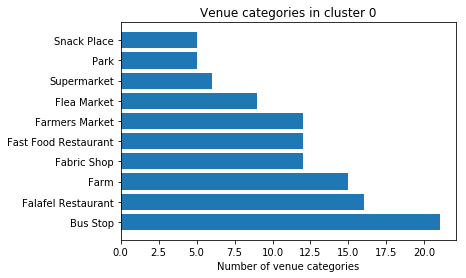

In [48]:
#count venue categories in all neighborhoods in the cluster
t0 = total_venue_categories(ams_merged[ams_merged['Cluster Labels'] == 0])

y_pos = np.arange(len(t0['Venue Category']))
plt.barh(y_pos, t0['Venue Count'], align='center')
plt.yticks(y_pos, t0['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 0')
 
plt.show()

This cluster shows venue categories like bus stops, supermarkets, markets, fast food restaurants so also residential areas but due to the fact that the bus stop it's the most popular venue category we could consider this the suburbs.

### Cluster 1 : Residential

In [49]:
ams_cluster1 = ams_merged.loc[ams_merged['Cluster Labels'] == 1, ams_merged.columns[[0] + list(range(2, ams_merged.shape[1]))]]
ams_cluster1

Neighborhood Borough code    Area m2   Latitude  \
0                   Calandlaan/Lelylaan            F   275360.0  52.355708   
1                       Osdorp Zuidoost            F   519366.0  52.353736   
3                    Osdorp Midden Zuid            F   258379.0  52.358838   
4         Zuidwestkwadrant Osdorp Noord            F   240774.0  52.355523   
5          Zuidwestkwadrant Osdorp Zuid            F   402284.0  52.350535   
6                               De Punt            F   481657.0  52.356332   
7               Bedrijvencentrum Osdorp            F   117961.0  52.360842   
8                 Overtoomse Veld Noord            F   344673.0  52.367066   
13             Koningin Wilhelminaplein            F   263637.0  52.354005   
16              Delflandpleinbuurt West            F   340440.0  52.348914   
21               Nieuw Sloten Noordwest            F   373530.0  52.347752   
22               Nieuw Sloten Noordoost            F   480227.0  52.348992   
23                     Belgiëplein e.o.            F    82888.7  52.345668   
24                Nieuw Sloten Zuidwest            F   231665.0  52.343669   
25                Nieuw Sloten Zuidoost            F   256133.0  52.344418   
113                       Landlust Zuid            E   216822.0  52.377509   
115                  Kolenkitbuurt Zuid            E   128037.0  52.377097   
116                 Kolenkitbuurt Noord            E   298892.0  52.381488   
127                             Buurt 3            F   699988.0  52.381924   
128                             Buurt 2            F   315102.0  52.378852   
129                     Slotermeer Zuid            F   434244.0  52.376340   
131                        Buurt 4 Oost            F   359221.0  52.381518   
132                       Buurt 5 Noord            F   231468.0  52.377585   
133                          Sloterpark            F  1061700.0  52.366183   
134                        Buurt 5 Zuid            F   320548.0  52.374266   
135                             Buurt 6            F   271028.0  52.374880   
136                             Buurt 7            F   297767.0  52.376597   
141                            Buurt 10            F   320952.0  52.381287   
143                            Wildeman            F   330000.0  52.362481   
144                       Meer en Oever            F   233504.0  52.363902   
..                                  ...          ...        ...        ...   
409                 Grunder/Koningshoef            T   131278.0  52.321343   
417           Middelveldsche Akerpolder            F   352026.0  52.353541   
418                        De Aker West            F   574212.0  52.350323   
419                        De Aker Oost            F   718473.0  52.347331   
420                Oostoever Sloterplas            F   647664.0  52.367993   
421            Emanuel van Meterenbuurt            F   584747.0  52.360781   
422                     Jacob Geelbuurt            F   321310.0  52.360823   
423                Overtoomse Veld Zuid            F   306464.0  52.361693   
431               Middeneiland Zuidwest            M   200760.0  52.353642   
432                       Centrumeiland            M   486368.0  52.352664   
433                    Haveneiland Oost            M   602024.0  52.348424   
434                        Park de Meer            M   263634.0  52.343558   
440                        Amstelglorie            M   506325.0  52.333169   
446                 Buiksloterdijk Oost            N    26845.5  52.396878   
448                     Werengouw Noord            N   163140.0  52.396048   
449                    Werengouw Midden            N   375722.0  52.394147   
450                   Markengouw Midden            N   405056.0  52.396903   
451                     Markengouw Zuid            N   226452.0  52.391177   
452                      Werengouw Zuid            N   220881.0  52.389233   
453                     Papaverweg e.o.          

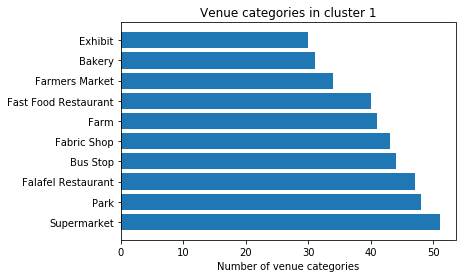

In [50]:
#count venue categories in all neighborhoods in the cluster
t1 = total_venue_categories(ams_merged[ams_merged['Cluster Labels'] == 1])

y_pos = np.arange(len(t1['Venue Category']))
plt.barh(y_pos, t1['Venue Count'], align='center')
plt.yticks(y_pos, t1['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 1')
 
plt.show()

In this cluster we see popular places like supermarkets, parks, bus stops, markets, bakeries etc..so these are popular places in the residential areas.

### Cluster 2: Soccer Field

In [51]:
ams_cluster2 = ams_merged.loc[ams_merged['Cluster Labels'] == 2, ams_merged.columns[[0] + list(range(2, ams_merged.shape[1]))]]
ams_cluster2

Neighborhood Borough code    Area m2   Latitude  Longitude  \
142                     Ookmeer            F   725431.0  52.369101   4.800276   
155         Buiksloterdijk West            N    26435.8  52.400271   4.918423   
158      Tuindorp Oostzaan West            N   181544.0  52.416493   4.879012   
169              Banne Zuidoost            N   525436.0  52.404177   4.918232   
189                      Huntum            T   119177.0  52.307488   4.962036   
191            Bijlmerpark West            T   510372.0  52.311244   4.964894   
195            Bijlmerpark Oost            T   154086.0  52.312504   4.968773   
208              Sloterweg e.o.            F   862588.0  52.338153   4.809844   
289                 De Wetbuurt            M   287637.0  52.343178   4.926967   
295  Sportpark Middenmeer Noord            M   251024.0  52.349894   4.949837   
324          Noorderstrook Oost            N   479312.0  52.396226   4.962887   
399               Oostzanerdijk            N   465963.0  52.419419   4.883078   
400                    Kadoelen            N  1305410.0  52.414378   4.909158   
403             Elzenhagen Zuid            N   312616.0  52.401105   4.927550   
429      Nieuwe Diep/Diemerpark            M  2399790.0  52.354212   4.985082   
435          Sportpark Voorland            M   269462.0  52.346818   4.955236   
439            Weespertrekvaart            M   482447.0  52.338666   4.931034   
476               Dorp Driemond            T   350714.0  52.305792   5.015748   

        Borough  Borough Area m2  Borough Latitude  Borough Longitude  \
142  Nieuw-West         38015500         52.363591           4.802676   
155       Noord         63828800         52.399439           4.967446   
158       Noord         63828800         52.399439           4.967446   
169       Noord         63828800         52.399439           4.967446   
189    Zuidoost         22113700         52.304654           4.975444   
191    Zuidoost         22113700         52.304654           4.975444   
195    Zuidoost         22113700         52.304654           4.975444   
208  Nieuw-West         38015500         52.363591           4.802676   
289        Oost         30594900         52.350438           4.967149   
295        Oost         30594900         52.350438           4.967149   
324       Noord         63828800         52.399439           4.967446   
399       Noord         63828800         52.399439           4.967446   
400       Noord         63828800         52.399439           4.967446   
403       Noord         63828800         52.399439           4.967446   
429        Oost         30594900         52.350438           4.967149   
435        Oost         30594900         52.350438           4.967149   
439        Oost         30594900         52.350438           4.967149   
476    Zuidoost         22113700         52.304654           4.975444   

     Population density  ...  1st Most Common Venue  2nd Most Common Venue  \
142               490.0  ...           Soccer Field         Baseball Field   
155                 NaN  ...           Soccer Field     Turkish Restaurant   
158              6728.0  ...               Creperie            Bus Station   
169              8162.0  ...           Soccer Field                 Church   
189              1825.0  ...           Soccer Field                  Track   
191                 NaN  ...                   Park           Soccer Field   
195              4260.0  ...           Soccer Field                  Track   
208               347.0  ...     Athletics & Sports           Soccer Field   
289              7012.0  ...           Soccer Field             Sports Bar   
295              1080.0  ...           Soccer Field                Stadium   
324                19.0  ...           Soccer Field                Stadium   
399               923.0  ...           Soccer Field                Stables   
400              2082.0  ...            Sports Club   Gym / Fitness Center   

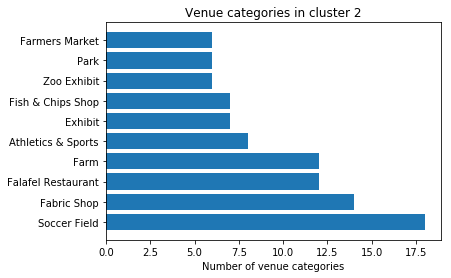

In [52]:
#count venue categories in all neighborhoods in the cluster
t2 = total_venue_categories(ams_merged[ams_merged['Cluster Labels'] == 2])

y_pos = np.arange(len(t2['Venue Category']))
plt.barh(y_pos, t2['Venue Count'], align='center')
plt.yticks(y_pos, t2['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 2')
 
plt.show()

Here in this cluster we see that the most popular venue category is the Soccer Field, followed by fast food restaurants, sport shops which indicate this cluster is very specific to soccer field areas. So we can see with no doubt that soccer is the most popular sport in Amsterdam.

### Cluster 3: Downtown

In [53]:
ams_cluster3 = ams_merged.loc[ams_merged['Cluster Labels'] == 3, ams_merged.columns[[0] + list(range(2, ams_merged.shape[1]))]]
ams_cluster3

Neighborhood Borough code    Area m2   Latitude  \
2                Osdorp Midden Noord            F   215541.0  52.362078   
9                Rembrandtpark Noord            F   304271.0  52.366990   
10                Rembrandtpark Zuid            F   316660.0  52.361088   
11               Johan Jongkindbuurt            F    86905.5  52.358607   
12      Lucas/Andreasziekenhuis e.o.            F   184923.0  52.371213   
14                    Andreasterrein            F   177407.0  52.355046   
15           Delflandpleinbuurt Oost            F   181654.0  52.348984   
17                       Riekerhaven            F   416534.0  52.341784   
18                  Schipluidenbuurt            F   116474.0  52.357001   
19                      Riekerpolder            F   645668.0  52.341658   
20                    Park Haagseweg            F   121305.0  52.343590   
26                       Hemonybuurt            K   139968.0  52.357005   
27                   Gerard Doubuurt            K   106349.0  52.356888   
28                   Frans Halsbuurt            K   121403.0  52.357684   
29             Hercules Seghersbuurt            K    84502.0  52.353820   
30                 Sarphatiparkbuurt            K   227571.0  52.355431   
31                 Willibrordusbuurt            K   124015.0  52.354155   
32           Van der Helstpleinbuurt            K   136228.0  52.353060   
33                Lizzy Ansinghbuurt            K   127547.0  52.350615   
34              Cornelis Troostbuurt            K   156513.0  52.350495   
35                Surinamepleinbuurt            K    89405.1  52.356423   
36                       Kop Zeedijk            A    80490.5  52.375723   
37                   BG-terrein e.o.            A   101294.0  52.369559   
38                Stationsplein e.o.            A   260407.0  52.379765   
39                         Hemelrijk            A    62939.6  52.378218   
40                  Spuistraat Noord            A    56780.6  52.375088   
41                  Nieuwe Kerk e.o.            A    84185.5  52.374417   
42                   Spuistraat Zuid            A    67106.3  52.370680   
43                    Kalverdriehoek            A    60379.2  52.367976   
44                  Langestraat e.o.            A   123316.0  52.378407   
..                               ...          ...        ...        ...   
391    Bedrijvengebied Zeeburgerkade            M    99542.9  52.366967   
394                      Julianapark            M   191935.0  52.346146   
395           Tuindorp Amstelstation            M   110022.0  52.344205   
410                   Geuzenhofbuurt            E    93667.7  52.372761   
411                       Trompbuurt            E   123075.0  52.372918   
412         Pieter van der Doesbuurt            E    74972.4  52.372876   
413                Kortenaerkwartier            E    99493.0  52.369864   
414       Filips van Almondekwartier            E    45055.2  52.369940   
415               De Wester Quartier            E    77507.0  52.366690   
416               Van Brakelkwartier            E    53595.1  52.366151   
424                     Diamantbuurt            K   167160.0  52.351218   
425  Burgemeester Tellegenbuurt Oost            K   121441.0  52.350304   
426  Burgemeester Tellegenbuurt West            K   102277.0  52.349831   
427               Prinses Irenebuurt            K   266469.0  52.343022   
428                      Beatrixpark            K   166601.0  52.343884   
436                Science Park Zuid            M   848664.0  52.353520   
442             Amstelkwartier Noord            M   368218.0  52.338608   
443                         De Omval            M   147924.0  52.344170   
444              Amstelkwartier Zuid            M   243461.0  52.334904   
445              Amstelkwartier West            M   255499.0  52.334952   
454           Cornelis Douwesterrein            N  1389640.0  52.409972   
455                     NDSM terrein            N

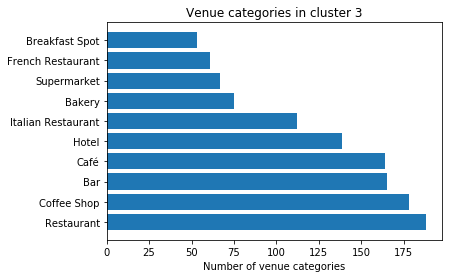

In [54]:
#count venue categories in all neighborhoods in the cluster
t3 = total_venue_categories(ams_merged[ams_merged['Cluster Labels'] == 3])

y_pos = np.arange(len(t3['Venue Category']))
plt.barh(y_pos, t3['Venue Count'], align='center')
plt.yticks(y_pos, t3['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 3')
 
plt.show()

This cluster shows popular venues like restaurants, coffee shops, cafes, bars, bakeries so this indicates this is the downtown area with popular places for going out activities.

### Cluster 4: Harbor

In [55]:
ams_cluster4 = ams_merged.loc[ams_merged['Cluster Labels'] == 4, ams_merged.columns[[0] + list(range(2, ams_merged.shape[1]))]]
ams_cluster4

Neighborhood Borough code    Area m2   Latitude  Longitude     Borough  \
197         L-buurt            T   763814.0  52.306821   4.979560    Zuidoost   
207     Nieuwe Meer            F  2273670.0  52.332711   4.825102  Nieuw-West   
472     Gaasperplas            T  1337700.0  52.306166   4.998129    Zuidoost   
474  Gein Noordoost            T   647836.0  52.299122   4.998584    Zuidoost   

     Borough Area m2  Borough Latitude  Borough Longitude  Population density  \
197         22113700         52.304654           4.975444              4346.0   
207         38015500         52.363591           4.802676               127.0   
472         22113700         52.304654           4.975444                50.0   
474         22113700         52.304654           4.975444              5224.0   

     ...  1st Most Common Venue  2nd Most Common Venue  3rd Most Common Venue  \
197  ...                   Park        Harbor / Marina             Playground   
207  ...                   Lake                   Park        Harbor / Marina   
472  ...                   Lake      Convention Center             Playground   
474  ...                   Lake             Playground            Zoo Exhibit   

     4th Most Common Venue  5th Most Common Venue 6th Most Common Venue  \
197                   Lake            Zoo Exhibit     Fish & Chips Shop   
207            Zoo Exhibit            Event Space           Fabric Shop   
472            Zoo Exhibit                Exhibit           Fabric Shop   
474            Fish Market                Exhibit           Fabric Shop   

    7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
197               Exhibit           Fabric Shop    Falafel Restaurant   
207    Falafel Restaurant                  Farm        Farmers Market   
472    Falafel Restaurant                  Farm        Farmers Market   
474    Falafel Restaurant                  Farm        Farmers Market   

    10th Most Common Venue  
197                   Farm  
207   Fast Food Restaurant  
472   Fast Food Restaurant  
474   Fast Food Restaurant  

[4 rows x 25 columns]

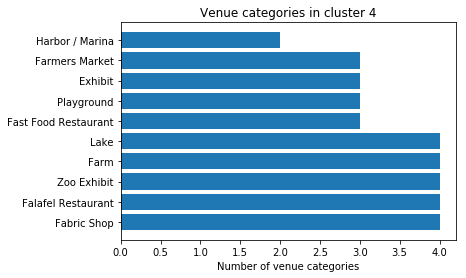

In [56]:
#count venue categories in all neighborhoods in the cluster
t4 = total_venue_categories(ams_merged[ams_merged['Cluster Labels'] == 4])

y_pos = np.arange(len(t4['Venue Category']))
plt.barh(y_pos, t4['Venue Count'], align='center')
plt.yticks(y_pos, t4['Venue Category'])
plt.xlabel('Number of venue categories')
plt.title('Venue categories in cluster 4')
 
plt.show()

This cluster shows the majorities of venues categories are lakes, exhibitons, farmers markets,  Harbor/Marina, restaurants,etc..so they are popular for the areas next to the water which is no surprise for Amsterdam that we get a cluster for neighborhoods around the harbors.

In [60]:
ams_merged.columns

Index(['Neighborhood', 'Neighborhood code', 'Borough code', 'Area m2',
       'Latitude', 'Longitude', 'Borough', 'Borough Area m2',
       'Borough Latitude', 'Borough Longitude', 'Population density',
       'New urbanities %', 'Couples with children %', 'Population',
       'Housing Density', 'Cluster Labels', '1st Most Common Venue',
       '2nd Most Common Venue', '3rd Most Common Venue',
       '4th Most Common Venue', '5th Most Common Venue',
       '6th Most Common Venue', '7th Most Common Venue',
       '8th Most Common Venue', '9th Most Common Venue',
       '10th Most Common Venue'],
      dtype='object')

In [57]:
boroughs_cluster=ams_merged.groupby(['Cluster Labels', 'Borough']).size().to_frame()
boroughs_cluster

0
Cluster Labels Borough       
0.0            Nieuw-West   4
               Noord       13
               Oost         2
               Zuidoost     2
1.0            Nieuw-West  39
               Noord       28
               Oost        24
               West         5
               Westpoort    2
               Zuid         8
               Zuidoost    24
2.0            Nieuw-West   2
               Noord        7
               Oost         5
               Zuidoost     4
3.0            Centrum     70
               Nieuw-West  18
               Noord       11
               Oost        38
               West        61
               Westpoort    1
               Zuid        68
               Zuidoost     9
4.0            Nieuw-West   1
               Zuidoost     3

## Discussion  <a name="discussion"></a>

Among the above clusters it would appear that the following clusters are best suited for families with children:

* _Cluster 0: Suburbs_. Venue categories in this cluster are mostly bus stops, fast food restaurants, farmers market, supermarkets which all suggests places where one can find something quick to eat maybe places inside malls which suggest residential areas.
* _Cluster 1: Residential_. Venue categories in this cluster are mostly shops with some interspersed coffee shops and restaurants as well as parks and sporting venues which is all suitable for families.
* _Cluster 4: Harbor_. Venue categories in this cluster are mostly categories for outdoor entertainment like harbor, zoo, exhibitions, fast food restaurants and also parks so seems also an interesting green area suited for families.

Let's do some analysis to verify these observations.

Check the average population/housing indicators in each cluster.

In [58]:
ams = ams_merged[['Cluster Labels', 'Area m2', 'Population density', 'New urbanities %', 'Couples with children %', 
                 'Population', 'Housing Density']].groupby(['Cluster Labels']).mean().reset_index()
ams

Cluster Labels       Area m2  Population density  New urbanities %  \
0             0.0  3.570818e+05         6547.100000         19.880000   
1             1.0  4.152290e+05         9250.634146         19.795200   
2             2.0  5.394136e+05         2863.333333         25.112500   
3             3.0  2.108962e+05        14591.588000         37.435955   
4             4.0  1.255755e+06         2436.750000         21.200000   

   Couples with children %   Population  Housing Density  
0                25.278947  2111.952381      2830.684211  
1                21.033607  2447.440000      4235.860656  
2                20.106250   929.875000      1440.266667  
3                12.668797  1773.503676      8489.848980  
4                21.900000  1611.750000      1113.000000

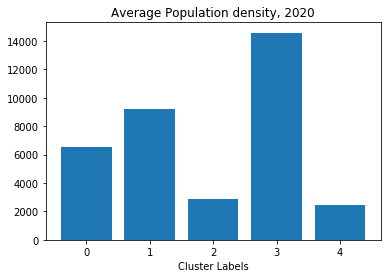

In [59]:
plt.bar(ams['Cluster Labels'], ams['Population density'], align='center')
plt.xlabel('Cluster Labels')
plt.title('Average Population density, 2020')
 
plt.show()

Judging by the population density we can say that indeed clusters 0, 1, 4 might be suitable for families with kids since are not overcrowded like we see in cluster 3 (downtown area).

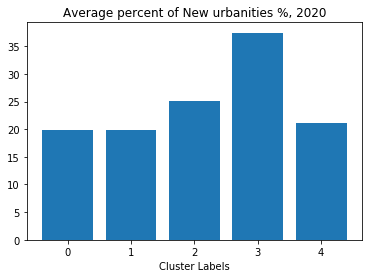

In [60]:
plt.bar(ams['Cluster Labels'], ams['New urbanities %'], align='center')
plt.xlabel('Cluster Labels')
plt.title('Average percent of New urbanities %, 2020')
 
plt.show()

Seems that newly citizens moving to Amsterdam chose the downtown cluster could be because they are young people coming to Amsterdam for studies and of course they prefer the busy areas with lots of entartainment options..the other clusters seems quite similar.

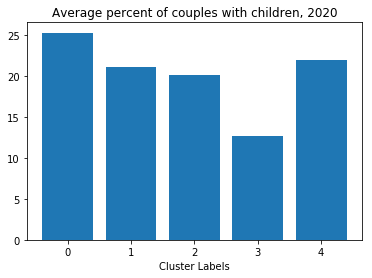

In [61]:
plt.bar(ams['Cluster Labels'], ams['Couples with children %'], align='center')
plt.xlabel('Cluster Labels')
plt.title('Average percent of couples with children, 2020')
 
plt.show()

Looking at the average couples with kids we verify our results from clustering the neighborhoods and see that most families with kids are indeed in clusters 0,1,4 with over 20%, but also cluster 2(Soccer Fields) seems it's an option for families with kids.

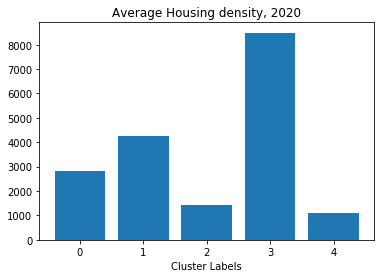

In [62]:
plt.bar(ams['Cluster Labels'], ams['Housing Density'], align='center')
plt.xlabel('Cluster Labels')
plt.title('Average Housing density, 2020')
 
plt.show()

Average housing density by clusters shows that most of the housing are in the downtown area (also the crowded area), followed by the clusters identified as potential best suited for residential living clusters 0 and 1. We can see that in cluster 4 the housing density it's significantly lower but it's expected as we saw also from the population density and also because it's a smaller area and it has more green space and it's proximity to the water.

Use Amsterdam Geojson file (found in the official municipality site) for plotting the map of neighborhoods

In [63]:
!wget --quiet 'https://maps.amsterdam.nl/open_geodata/geojson.php?KAARTLAAG=GEBIED_BUURTEN&THEMA=gebiedsindeling' -O ams_geojson.json
  
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [70]:
map_clusters_s=map_clusters

ams_geo = r'ams_geojson.json'

folium.Choropleth(geo_data=ams_geo,
    data = ams_data,
    columns=['Neighborhood code','Population density'],
    key_on='feature.properties.Buurt_code',
    fill_color='YlOrRd',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population density per Neighborhood').add_to(map_clusters_s)

map_clusters_s

We seen even better on the map that the cluster 3 (downtown) is a very populated area and this would not be suited for a family with kids, but instead the areas from cluster 0,1 are better options and less population density in there.

In [74]:
map_clusters_s1=map_clusters
folium.Choropleth(geo_data=ams_geo,
    data = ams_data,
    columns=['Neighborhood code','Couples with children %'],
    key_on='feature.properties.Buurt_code',
    fill_color='YlOrRd',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Percentage of couples with children').add_to(map_clusters_s1)

map_clusters_s1

This visualisation confirm what we thought about the best neighbourhoods for couples with children and this means looking at clusters 0(suburbs),1(residential),4(harbor) and even 2(soccer field) but avoiding cluster 3(downtown) where we see the least percentage of couples with kids.

Finally let's compare with reality and what are Amsterdam's popular neighborhoods

In [65]:
#Neighborhoods I will flag as best for living 

#'Prinsengracht', 'Herengracht', 'Keizersgracht' - A02
#'Jordaan' - A06
#'dePijp, Rivierenbuurt' - K25, K24,K52
#'Diamantbuurt - K26
#'Apollobuurt' - K59
#'Indische Buurt' - M31,M32
#'Stadionbuurt' - K48
#'Vondelpark' - K46, K47
#'Transvaalbuurt' - M30
#'Westerpark', 'Spaarndammerbuurt' - E13
#'Bos en Lommer' - E39
#'Slotervaart' - F85, F86, F87, F89
#'Buitenveldert' - K90,K91
#'Oostenlijke Havengebied' - M33

list_flag = ams_data[ams_data['Neighborhood code'].str.contains('A02c|A06a|K24a|K25a|K26a|K52a|K59a|M31a|M32a|K46d|K47a|K48d|M30a|E13f|E39a|F85a|F86a|F87a|F89a|K90a|K91a|M33b')]
list_flag = list_flag[['Neighborhood', 'Neighborhood code']]

ams_flag = pd.DataFrame(data =list_flag, columns= ['Neighborhood', 'Neighborhood code'])
ams_flag.insert(ams_flag.shape[1], 'Top_flag', 1)
ams_flag

Neighborhood Neighborhood code  Top_flag
8                     Overtoomse Veld Noord              F86a         1
13                 Koningin Wilhelminaplein              F87a         1
26                              Hemonybuurt              K24a         1
31                        Willibrordusbuurt              K25a         1
46                       Felix Meritisbuurt              A02c         1
62                            Driehoekbuurt              A06a         1
218                  Johannnes Vermeerbuurt              K47a         1
236                          Wielingenbuurt              K52a         1
247                    Gelderlandpleinbuurt              K90a         1
250                         De Klenckebuurt              K91a         1
263                     Transvaalbuurt West              M30a         1
265  Noordwestkwadrant Indische buurt Noord              M31a         1
268        Noordoostkwadrant Indische buurt              M32a         1
316                     Louis Crispijnbuurt              F89a         1
367             Spaarndammerbuurt Noordwest              E13f         1
372                  Robert Scottbuurt West              E39a         1
384                         Vondelpark West              K46d         1
385                  Olympisch Stadion e.o.              K48d         1
389                              Rietlanden              M33b         1
420                    Oostoever Sloterplas              F85a         1
424                            Diamantbuurt              K26a         1
427                      Prinses Irenebuurt              K59a         1

Add the flag column to the main table with Amsterdam information on neighborhoods

In [66]:
amsf = ams_flag.merge(ams_merged, on = ['Neighborhood','Neighborhood code'], how='left')
amsf = amsf[~amsf['Cluster Labels'].isna()]
amsf['Cluster Labels'] = amsf['Cluster Labels'].astype(int)
amsf.shape

(22, 27)

Display the flagged real popular neighborhoods of Amsterdam on the map

In [76]:
for lat, lon, neigh, flg in zip(amsf['Latitude'], amsf['Longitude'], amsf['Neighborhood'], amsf['Top_flag']):
    label = folium.Popup(neigh, parse_html=True)
    folium.Marker(
    [lat, lon],
    popup=label).add_to(map_clusters_s1)
       
map_clusters_s1

Seeing the popular neighborhoods on our map with the clusters and with the percentage of couples with kids helps us identify neighborhoods where would be best to live and also consider cheaper living costs(if we avoid the flagged popular neighborhoods but choose a similar neighborhood from same cluster as a popular one).

In [81]:
#Check how many flagged neighborhoods we have for each cluster
amsf_g = amsf[['Cluster Labels', 'Neighborhood']]
amsf_g.groupby('Cluster Labels').count()

Neighborhood
Cluster Labels              
1                          6
3                         16

We can see that most of the popular neighborhoods are in cluster 3(Downtown) and few in the residential cluster 1 so this means there are many neighborhoods to choose from in Cluster 1 or even 0,4 and 2.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify the best suited neighborhoods in Amsterdam for couples with kids in order to help them to choose a rent or buy a property. We gather existing informations from Amsterdam Municipality data for boroughs and neighborhoods and use the Forsquare API to identify venue categories within a radius from each neighborhood. Clustering of neighborhoods with their most popular venues was peformed in order to identify interesting neighborhoods best suited for families with kids.

Final decision will be made by families based on specific characteristics of neighborhoods and their locations in the recommended clusters, of course they will take in consideration other aspects like proximity to schools, parks, real estate prices or other socio/economic factors of each neighborhood.